Dataset: 
https://www.kaggle.com/fivethirtyeight/the-ultimate-halloween-candy-power-ranking

Tutorial:
https://www.datacamp.com/courses/model-validation-in-python

This project is about the model validation using random forest as an example.
I compared the traditional train, cross-validation, and test set method and the Kfold method.


In [129]:
from datetime import datetime
from typing import List, Dict
import re
from typing import List, Tuple

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from sklearn.utils.fixes import signature
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, \
roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, precision_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline 


# (1) Traditional train, cross validation, and test split

In [147]:
def split_to_features_labels(df: pd.DataFrame, non_feature_list: List, label_list: List) -> Tuple[pd.DataFrame, pd.Series]:
    """ Split the data into feature matrix and the labels vector"""
    df_features = df.drop(non_feature_list, axis=1)
    df_label = df[label_list]
    return df_features, df_label

def get_model_results_classification(X_train, y_train, X_test, y_test, model):
    """Train the model and evalute it"""

    model.fit(X_train, np.ravel(y_train))
    predicted = model.predict(X_test)
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, pos_label="positive")
    print('Accuracy: ', accuracy)
    print('precision: ', precision)
    print('Classification report \n', classification_report(y_test, predicted))
    print('Confusion matrix \n', confusion_matrix(y_test, predicted))
    return predicted, accuracy, precision

### Regression

In [148]:
df_original = pd.read_csv("candy-data.csv")
print(df_original.columns)

df = df_original.copy()
X, y = split_to_features_labels(df, non_feature_list=['winpercent', 'competitorname'], label_list=['winpercent'])



Index(['competitorname', 'chocolate', 'fruity', 'caramel', 'peanutyalmondy',
       'nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'sugarpercent',
       'pricepercent', 'winpercent'],
      dtype='object')


In [149]:
# Create temporary training and final testing datasets
X_temp, X_test, y_temp, y_test  =\
    train_test_split(X, y, test_size=0.2, random_state=1111)

# Create the final training and validation datasets
X_train, X_val, y_train, y_val =\
    train_test_split(X_temp, y_temp, test_size=0.25, random_state=1111)

In [150]:
rfr = RandomForestRegressor()
rfr.n_estimators = 100
rfr.max_depth = 6
rfr.random_state = 1111


In [151]:
rfr.fit(X_train, y_train)


c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=1111, verbose=0, warm_start=False)

In [152]:
rfr.feature_importances_

array([0.42616758, 0.02322259, 0.03831592, 0.04979953, 0.01117358,
       0.05099189, 0.00515225, 0.02361801, 0.02436229, 0.17341657,
       0.17377979])

In [153]:
# Print how important each column is to the model
for i, item in enumerate(rfr.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

chocolate: 0.43
fruity: 0.02
caramel: 0.04
peanutyalmondy: 0.05
nougat: 0.01
crispedricewafer: 0.05
hard: 0.01
bar: 0.02
pluribus: 0.02
sugarpercent: 0.17
pricepercent: 0.17


In [154]:
train_predictions = rfr.predict(X_train)
val_predictions = rfr.predict(X_val)
print(mean_absolute_error(y_true=y_train, y_pred=train_predictions))
print(mean_absolute_error(y_true=y_val, y_pred=val_predictions))
print(mean_squared_error(y_true=y_train, y_pred=train_predictions))
print(mean_squared_error(y_true=y_val, y_pred=val_predictions))
      

3.687512835488868
9.2037116475282
21.03189610483642
131.50787837403146


### Classification

In [179]:
df_original = pd.read_csv("tic-tac-toe.csv")
df_original.columns

Index(['Top-Left', 'Top-Middle', 'Top-Right', 'Middle-Left', 'Middle-Middle',
       'Middle-Right', 'Bottom-Left', 'Bottom-Middle', 'Bottom-Right',
       'Class'],
      dtype='object')

In [180]:
df = df_original.copy()
X, y = split_to_features_labels(df, non_feature_list=['Class'], label_list=['Class'])


In [181]:
# Convert to numeric value by using the dummies
X = pd.get_dummies(X)

In [182]:
# Create temporary training and final testing datasets
X_temp, X_test, y_temp, y_test  =\
    train_test_split(X, y, test_size=0.2, random_state=1111)

# Create the final training and validation datasets
X_train, X_val, y_train, y_val =\
    train_test_split(X_temp, y_temp, test_size=0.25, random_state=1111)

#### Tuning the model


#### set 1  underfitting, the tree is not deep enough


In [199]:
rfc = RandomForestClassifier(random_state=1111)
rfc.n_estimators=50
rfc.max_depth = 6


In [200]:
# get the parameter
print(rfc)

# Print the classification model's random state parameter
print('The random state is: {}'.format(rfc.random_state))

# Print all parameters
print('Printing the parameters dictionary: {}'.format(rfc.get_params()))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=1111, verbose=0,
            warm_start=False)
The random state is: 1111
Printing the parameters dictionary: {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 1111, 'verbose': 0, 'warm_start': False}


In [201]:
predicted, accuracy, precision = get_model_results_classification(X_train, y_train, X_val, y_val, rfc)

# accuracy for the cross validation set
print(rfc.score(X_val, y_val))
print(accuracy_score(y_val, rfc.predict(X_val)))

# Print out count of binary predictions
print('\n', pd.Series(predicted).value_counts())


Accuracy:  0.8854166666666666
precision:  0.8671328671328671
Classification report 
               precision    recall  f1-score   support

    negative       0.94      0.71      0.81        65
    positive       0.87      0.98      0.92       127

   micro avg       0.89      0.89      0.89       192
   macro avg       0.90      0.84      0.86       192
weighted avg       0.89      0.89      0.88       192

Confusion matrix 
 [[ 46  19]
 [  3 124]]
0.8854166666666666
0.8854166666666666

 positive    143
negative     49
dtype: int64


In [203]:
#  evaluate the test set
predicted_test = rfc.predict(X_test)

print(rfc.score(X_test, y_test))
print(accuracy_score(y_test, predicted_test), '\n')
print(confusion_matrix(y_test, predicted_test), '\n')
print(classification_report(y_test, predicted_test), '\n')


# Create arrays of predictions for test set. 
probability_predictions = rfc.predict_proba(X_test)
print('The first predicted probabilities are: {}'.format(probability_predictions[0]), '\n')


0.859375
0.859375 

[[ 37  23]
 [  4 128]] 

              precision    recall  f1-score   support

    negative       0.90      0.62      0.73        60
    positive       0.85      0.97      0.90       132

   micro avg       0.86      0.86      0.86       192
   macro avg       0.88      0.79      0.82       192
weighted avg       0.86      0.86      0.85       192
 

The first predicted probabilities are: [0.19720733 0.80279267] 



#### set 2 under fitting, not enough number of trees


In [209]:
rfc = RandomForestClassifier(random_state=1111)
rfc.n_estimators=10
rfc.max_depth = 6
predicted, accuracy, precision = get_model_results_classification(X_train, y_train, X_val, y_val, rfc)


Accuracy:  0.8697916666666666
precision:  0.875
Classification report 
               precision    recall  f1-score   support

    negative       0.86      0.74      0.79        65
    positive       0.88      0.94      0.90       127

   micro avg       0.87      0.87      0.87       192
   macro avg       0.87      0.84      0.85       192
weighted avg       0.87      0.87      0.87       192

Confusion matrix 
 [[ 48  17]
 [  8 119]]


In [210]:
#  evaluate the test set
predicted_test = rfc.predict(X_test)

print(rfc.score(X_test, y_test))
print(accuracy_score(y_test, predicted_test), '\n')
print(confusion_matrix(y_test, predicted_test), '\n')
print(classification_report(y_test, predicted_test), '\n')


0.8697916666666666
0.8697916666666666 

[[ 38  22]
 [  3 129]] 

              precision    recall  f1-score   support

    negative       0.93      0.63      0.75        60
    positive       0.85      0.98      0.91       132

   micro avg       0.87      0.87      0.87       192
   macro avg       0.89      0.81      0.83       192
weighted avg       0.88      0.87      0.86       192
 



##### set 3: increase the depth of the tree


In [211]:
rfc = RandomForestClassifier(random_state=1111)
rfc.n_estimators=50
rfc.max_depth = 20
predicted, accuracy, precision = get_model_results_classification(X_train, y_train, X_val, y_val, rfc)


Accuracy:  0.96875
precision:  0.9548872180451128
Classification report 
               precision    recall  f1-score   support

    negative       1.00      0.91      0.95        65
    positive       0.95      1.00      0.98       127

   micro avg       0.97      0.97      0.97       192
   macro avg       0.98      0.95      0.96       192
weighted avg       0.97      0.97      0.97       192

Confusion matrix 
 [[ 59   6]
 [  0 127]]


In [212]:
#  evaluate the test set
predicted_test = rfc.predict(X_test)

print(rfc.score(X_test, y_test))
print(accuracy_score(y_test, predicted_test), '\n')
print(confusion_matrix(y_test, predicted_test), '\n')
print(classification_report(y_test, predicted_test), '\n')


0.9791666666666666
0.9791666666666666 

[[ 56   4]
 [  0 132]] 

              precision    recall  f1-score   support

    negative       1.00      0.93      0.97        60
    positive       0.97      1.00      0.99       132

   micro avg       0.98      0.98      0.98       192
   macro avg       0.99      0.97      0.98       192
weighted avg       0.98      0.98      0.98       192
 



#### set 4: more features


In [213]:
rfc = RandomForestClassifier(random_state=1111)
rfc.n_estimators = 50
rfc.max_depth = 20
rfc.max_features = 20
predicted, accuracy, precision = get_model_results_classification(X_train, y_train, X_val, y_val, rfc)

Accuracy:  0.9895833333333334
precision:  0.9844961240310077
Classification report 
               precision    recall  f1-score   support

    negative       1.00      0.97      0.98        65
    positive       0.98      1.00      0.99       127

   micro avg       0.99      0.99      0.99       192
   macro avg       0.99      0.98      0.99       192
weighted avg       0.99      0.99      0.99       192

Confusion matrix 
 [[ 63   2]
 [  0 127]]


In [214]:
#  evaluate the test set
predicted_test = rfc.predict(X_test)

print(rfc.score(X_test, y_test))
print(accuracy_score(y_test, predicted_test), '\n')
print(confusion_matrix(y_test, predicted_test), '\n')
print(classification_report(y_test, predicted_test), '\n')


0.9739583333333334
0.9739583333333334 

[[ 56   4]
 [  1 131]] 

              precision    recall  f1-score   support

    negative       0.98      0.93      0.96        60
    positive       0.97      0.99      0.98       132

   micro avg       0.97      0.97      0.97       192
   macro avg       0.98      0.96      0.97       192
weighted avg       0.97      0.97      0.97       192
 



### loop to test many trees

The training scores were: [0.9, 0.88, 0.96, 0.97, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0]
The testing scores were: [0.7, 0.76, 0.83, 0.85, 0.89, 0.93, 0.98, 0.97, 0.97, 0.98]


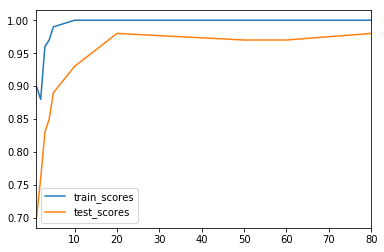

In [219]:
num_trees_list = [1, 2, 3, 4, 5, 10, 20, 50, 60, 80]
test_scores, train_scores = [], []
for i in num_trees_list:
    rfc = RandomForestClassifier(n_estimators=i, random_state=1111)
    rfc.fit(X_train, np.ravel(y_train))
    # Create predictions for the X_train and X_test datasets.
    train_predictions = rfc.predict(X_train)
    val_predictions = rfc.predict(X_val)
    # Append the accuracy score for the test and train predictions.
    train_scores.append(round(accuracy_score(y_train, train_predictions), 2))
    test_scores.append(round(accuracy_score(y_val, val_predictions), 2))
# Print the train and test scores.
print("The training scores were: {}".format(train_scores))
print("The testing scores were: {}".format(test_scores))

df_plot = pd.concat([pd.Series(train_scores), pd.Series(test_scores)], axis=1)
df_plot.columns = ['train_scores', 'test_scores']
df_plot.index = num_trees_list
df_plot.plot()

### the problem of traditional train, test split

In [220]:
tic_tac_toe = pd.read_csv("tic-tac-toe.csv")
# Create two different samples of 200 observations 
sample1 = tic_tac_toe.sample(200, random_state=1111)
sample2 = tic_tac_toe.sample(200, random_state=1171)

# Print the number of common observations 
print(len([index for index in sample1.index if index in sample2.index]))

# Print the number of observations in the Class column for both samples 
print(sample1['Class'].value_counts())
print(sample2['Class'].value_counts())

40
positive    134
negative     66
Name: Class, dtype: int64
positive    123
negative     77
Name: Class, dtype: int64


In [25]:
# If our models are not generalizing well or if we have limited data, we should be careful using a single 
# training/validation split. You should use the next lesson's topic: cross-validation.

# (2) Cross validation

### (2.1) use KFold

In [237]:
df_original = pd.read_csv("candy-data.csv")
df = df_original.copy()
X, y = split_to_features_labels(df, non_feature_list=['winpercent', 'competitorname'], label_list=['winpercent'])
y = np.ravel(y)
X = X.to_numpy()
X_temp, X_test, y_temp, y_test  = train_test_split(X, y, test_size=0.2, random_state=1111)

kf = KFold(n_splits=5, shuffle=False, random_state=1111)
splits = kf.split(X_temp)

rfc = RandomForestRegressor(n_estimators=25, random_state=1111)

# Access the training and validation indices of splits
error_array = []
for train_index, val_index in splits:
    print("Number of training indices: %s" % len(train_index))
    print("Number of validation indices: %s" % len(val_index))
    # Setup the training and validation data
    X_train, y_train = X_temp[train_index], y_temp[train_index]
    X_val, y_val = X_temp[val_index], y_temp[val_index]
    
    rfc.fit(X_train, y_train)

    predictions = rfc.predict(X_val)
    error = mean_squared_error(y_val, predictions)
    print("Split accuracy: " + str(error))
    error_array.append(error)
    
print('\n', np.mean(error_array))

Number of training indices: 54
Number of validation indices: 14
Split accuracy: 167.73866957411178
Number of training indices: 54
Number of validation indices: 14
Split accuracy: 95.53148961183506
Number of training indices: 54
Number of validation indices: 14
Split accuracy: 130.25635761522634
Number of training indices: 55
Number of validation indices: 13
Split accuracy: 163.503258769309
Number of training indices: 55
Number of validation indices: 13
Split accuracy: 159.25638660051754

 143.25723243419995


### (2.2) use sklearn's cross_val_score()


In [238]:
df_original = pd.read_csv("candy-data.csv")
df = df_original.copy()
X, y = split_to_features_labels(df, non_feature_list=['winpercent', 'competitorname'], label_list=['winpercent'])
y = np.ravel(y)
X = X.to_numpy()
X_temp, X_test, y_temp, y_test  = train_test_split(X, y, test_size=0.2, random_state=1111)


rfc = RandomForestRegressor(n_estimators=25, random_state=1111)
mse = make_scorer(mean_squared_error)

# Set up cross_val_score
cv = cross_val_score(estimator=rfc,
                     X=X_temp,
                     y=y_temp,
                     cv=5,
                     scoring=mse)

# Print the mean error
print(cv)
print(cv.mean())


[167.73866957  95.53148961 130.25635762 163.50325877 159.2563866 ]
143.25723243419995


### Leave-one-out-cross-validation


In [239]:
rfc = RandomForestRegressor(n_estimators=25, random_state=1111)
mse = make_scorer(mean_squared_error)

# Set up cross_val_score
cv = cross_val_score(estimator=rfc,
                     X=X,
                     y=y,
                     cv=X.shape[0],
                     scoring=mse)

# Print the mean error
print(cv)
print(cv.mean())


[6.90543183e-01 6.92920425e+02 1.11787314e+02 2.30869627e+02
 1.46528984e+02 2.55470743e+02 1.76068084e+02 2.18034723e+02
 5.47226985e-01 9.27087887e+01 6.44558479e+02 9.81079686e+01
 6.13625697e+02 3.49029728e-01 2.81303652e-01 8.27226816e+01
 3.14097753e+00 3.06427865e+00 1.71765407e+02 3.69309107e+01
 1.22920270e+01 1.20663383e+02 1.79614566e+02 2.38034036e+01
 2.00498747e+00 8.86263498e+00 2.90797904e+02 1.00674708e+02
 5.52211032e+02 5.09115540e+00 2.32292865e+01 1.03227747e+02
 4.06608367e+00 9.36373415e+00 6.52522271e+00 2.25397399e+00
 1.55018596e+02 5.54894721e+00 1.10063538e+01 1.38492996e+02
 6.96092513e+00 1.15460655e+02 1.44391558e+02 2.63546523e+01
 4.77070072e+02 9.37687348e+01 1.44636065e+02 1.93501864e+01
 1.81247894e+00 1.26072965e+01 1.12332436e+02 9.05971802e+02
 1.83062278e+02 2.48601273e+02 1.19549978e-01 6.21624031e+00
 2.89602861e+01 8.14911516e+01 4.76245441e+01 3.23579597e+02
 1.24708504e+02 2.56965968e+00 3.95071710e+02 5.76635297e+00
 4.68033939e+01 1.844001

# (3) RandomizedSearch

### Regression problem

In [242]:
# Prepare the data
df = pd.read_csv("candy-data.csv")
X, y = split_to_features_labels(df, non_feature_list=['winpercent', 'competitorname'], label_list=['winpercent'])
y = np.ravel(y)
X = X.to_numpy()
X_temp, X_test, y_temp, y_test  = train_test_split(X, y, test_size=0.2, random_state=1111)

# Set parameters
scorer = make_scorer(mean_squared_error)
param_dist = {"max_depth": [2, 4, 6, 8],
              "max_features": [2, 4, 6, 8, 10],
              "min_samples_split": [2, 4, 8, 16]}
rfr = RandomForestRegressor(n_estimators=10, random_state=1111)

rs = RandomizedSearchCV(estimator=rfr, 
                        param_distributions=param_dist,
                        scoring = scorer,
                        cv=5, 
                        n_iter=10, 
                        random_state=1111)

rs.fit(X_temp, y_temp)


c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1111, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [2, 4, 6, 8], 'max_features': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8, 16]},
          pre_dispatch='2*n_jobs', random_state=1111, refit=True,
          return_train_score='warn',
          scoring=make_scorer(mean_squared_error), verbose=0)

### evaluate the model

In [243]:
mean_test_score = rs.cv_results_['mean_test_score']
print('mean_test_score = ', mean_test_score, '\n')
print('best_score = ', rs.best_score_, '\n')
print('best_params = ', rs.best_params_, '\n')
print('params', rs.cv_results_['params'], '\n')

# Max_depth vs params table
max_depth = [item['max_depth'] for item in rs.cv_results_['params']]
print('max_depth = ', max_depth, '\n')
scores = list(rs.cv_results_['mean_test_score'])
d = pd.DataFrame([max_depth, scores]).T
d.columns = ['Max Depth', 'Score']
print(d.groupby(['Max Depth']).mean(), '\n')

# score of the model, can compare to other model
print('score of the model', rs.score(X_temp, y_temp))


mean_test_score =  [139.77362145 145.75417836 147.98647683 149.54197624 136.55358739
 125.25619705 142.71851263 146.39508123 155.46220574 128.11277612] 

best_score =  155.46220573794935 

best_params =  {'min_samples_split': 2, 'max_features': 10, 'max_depth': 2} 

params [{'min_samples_split': 8, 'max_features': 6, 'max_depth': 6}, {'min_samples_split': 16, 'max_features': 10, 'max_depth': 4}, {'min_samples_split': 16, 'max_features': 10, 'max_depth': 2}, {'min_samples_split': 8, 'max_features': 10, 'max_depth': 6}, {'min_samples_split': 4, 'max_features': 8, 'max_depth': 4}, {'min_samples_split': 4, 'max_features': 4, 'max_depth': 8}, {'min_samples_split': 8, 'max_features': 10, 'max_depth': 4}, {'min_samples_split': 16, 'max_features': 10, 'max_depth': 6}, {'min_samples_split': 2, 'max_features': 10, 'max_depth': 2}, {'min_samples_split': 2, 'max_features': 8, 'max_depth': 8}] 

max_depth =  [6, 4, 2, 6, 4, 8, 4, 6, 2, 8] 

                Score
Max Depth            
2.0        151

### predict 

In [245]:
print('best_estimator_ = ', rs.best_estimator_, '\n')
print(rs.best_estimator_.get_params(), '\n')


predicted = rs.best_estimator_.predict(X_test)

print(mean_absolute_error(y_true=y_test, y_pred=predicted))


best_estimator_ =  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False,
           random_state=1111, verbose=0, warm_start=False) 

{'bootstrap': True, 'criterion': 'mse', 'max_depth': 2, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 1111, 'verbose': 0, 'warm_start': False} 

9.652357768195126


### Save model for use later:

In [246]:
joblib.dump(rs, 'rfr_best_2019.5.21.pkl')

['rfr_best_2019.5.21.pkl']

### Classification problem

In [247]:
# Prepare the data
df = pd.read_csv("tic-tac-toe.csv")
X, y = split_to_features_labels(df, non_feature_list=['Class'], label_list=['Class'])
X = pd.get_dummies(X)
y = np.ravel(np.where(y =='positive', 1, 0))
X_temp, X_test, y_temp, y_test  = train_test_split(X, y, test_size=0.2, random_state=1111)


# Set the parameters
precision = make_scorer(precision_score)
param_dist = {"max_depth": [2, 4, 6, 8],
              "max_features": [2, 4, 6, 8, 10],
              "min_samples_split": [2, 4, 8, 16]}
rfc = RandomForestClassifier(n_estimators=10, random_state=1111)


rs = RandomizedSearchCV(estimator=rfc, 
                        param_distributions=param_dist,
                        scoring = precision,
                        cv=5, 
                        n_iter=10, 
                        random_state=1111)

rs.fit(X_temp, y_temp)


c:\program files (x86)\python37-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1111, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': [2, 4, 6, 8], 'max_features': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 8, 16]},
          pre_dispatch='2*n_jobs', random_state=1111, refit=True,
          return_train_score='warn', scoring=make_scorer(precision_score),
          verbose=0)

### evaluate the model


In [248]:
mean_test_score = rs.cv_results_['mean_test_score']
print('mean_test_score = ', mean_test_score, '\n')
print('best_score = ', rs.best_score_, '\n')
print('best_params = ', rs.best_params_, '\n')
print('params', rs.cv_results_['params'], '\n')

# Max_depth vs params table
max_depth = [item['max_depth'] for item in rs.cv_results_['params']]
print('max_depth = ', max_depth, '\n')
scores = list(rs.cv_results_['mean_test_score'])
d = pd.DataFrame([max_depth, scores]).T
d.columns = ['Max Depth', 'Score']
print(d.groupby(['Max Depth']).mean(), '\n')

# score of the model, can compare to other model
print('score of the model', rs.score(X_temp, y_temp))


mean_test_score =  [0.84082907 0.78830425 0.70264725 0.8828238  0.76684    0.8988839
 0.78932828 0.87218418 0.70264725 0.93442478] 

best_score =  0.9344247778769172 

best_params =  {'min_samples_split': 2, 'max_features': 8, 'max_depth': 8} 

params [{'min_samples_split': 8, 'max_features': 6, 'max_depth': 6}, {'min_samples_split': 16, 'max_features': 10, 'max_depth': 4}, {'min_samples_split': 16, 'max_features': 10, 'max_depth': 2}, {'min_samples_split': 8, 'max_features': 10, 'max_depth': 6}, {'min_samples_split': 4, 'max_features': 8, 'max_depth': 4}, {'min_samples_split': 4, 'max_features': 4, 'max_depth': 8}, {'min_samples_split': 8, 'max_features': 10, 'max_depth': 4}, {'min_samples_split': 16, 'max_features': 10, 'max_depth': 6}, {'min_samples_split': 2, 'max_features': 10, 'max_depth': 2}, {'min_samples_split': 2, 'max_features': 8, 'max_depth': 8}] 

max_depth =  [6, 4, 2, 6, 4, 8, 4, 6, 2, 8] 

              Score
Max Depth          
2.0        0.702647
4.0        0.781491


### Predict

In [249]:
print('best_estimator_ = ', rs.best_estimator_, '\n')
print(rs.best_estimator_.get_params(), '\n')


predicted = rs.best_estimator_.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))
print(accuracy_score(y_test, predicted))

best_estimator_ =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1111, verbose=0,
            warm_start=False) 

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 8, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 1111, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        60
           1       0.97      0.98      0.98       132

   micro avg       0.97 